<center>
    
    COMP4240/5435 - Reinforcement Learning
    
# Homework 8 - Policy Gradient

    
</center>


*Author* Name: ______________________


**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone.
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array.
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

The purpose of this project is to study different properties of Policy Gradient algorithms with Function Approximation.

In [ ]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


![mc.png](attachment:mc.png)


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.




**Note:** You have been given a simple implementation of the Mountain Car task. You can use your implementation of the function approximation from Homework 6, or implement a new one.


## Part I (40 points)

Implement **ACTOR-CRITIC with Eligibility Traces** (p. 332).



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.995
Episode 10/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.946354579813443
Episode 20/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.9000874278732445
Episode 30/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.8560822709551227
Episode 40/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.8142285204175609
Episode 50/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.7744209942832988
Episode 60/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.736559652908221
Episode 70/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.7005493475733617
Episode 80/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.6662995813682115
Episode 90/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.6337242817644086
Episode 100/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.6027415843082742
Episode 110/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.5732736268885887
Episode 120/2000 - Reward: -200.0 - Steps: 200 - Epsilon: 0.5452463540625918
Episode 130/2000 - Reward

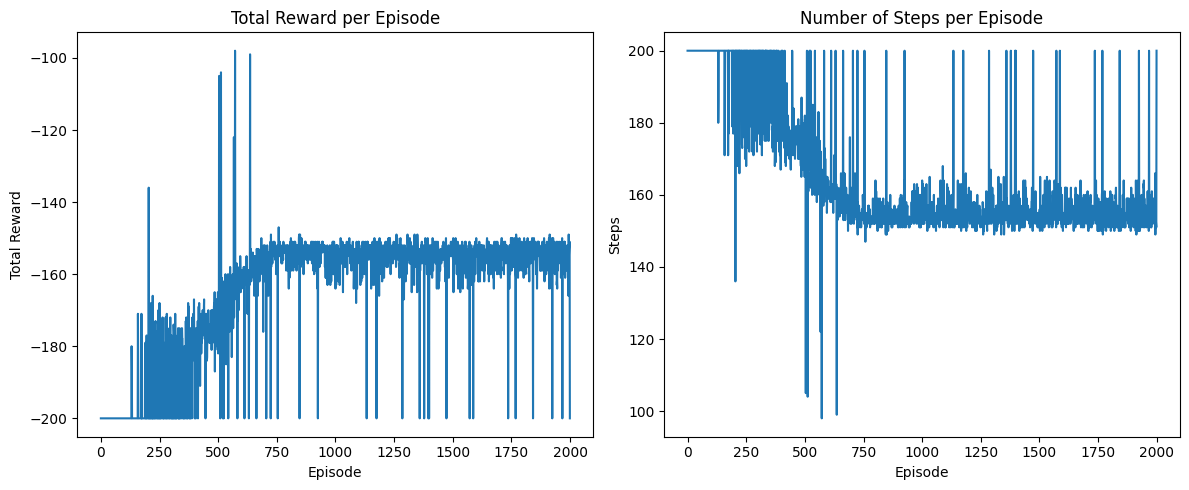

In [ ]:


import numpy as np
import gym
import matplotlib.pyplot as plt
import itertools

def fourier_basis(state, order, env_low, env_high):
    # Transform state to [0, 1]
    state_normalized = (state - env_low) / (env_high - env_low)


    # Create a multi-index to generate basis
    indices = [range(o + 1) for o in order]


    # Generate Fourier basis
    c = np.array([np.prod(np.cos(np.pi * np.array(i) * state_normalized)) for i in itertools.product(*indices)])
    return c

class ActorCriticWithEligibilityTraces:
    def __init__(self, env, actor_lr=0.01, critic_lr=0.01, gamma=0.99, lambda_=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, fourier_order=3):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min


        # Parameters
        self.order = [fourier_order] * self.state_size
        self.env_low = env.observation_space.low
        self.env_high = env.observation_space.high


        # Weights for the Fourier basis
        fourier_basis_size = np.product([o + 1 for o in self.order])
        self.actor_weights = np.zeros((fourier_basis_size, self.action_size))
        self.critic_weights = np.zeros(fourier_basis_size)
        self.actor_traces = np.zeros_like(self.actor_weights)
        self.critic_traces = np.zeros_like(self.critic_weights)

    def policy(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        z = np.dot(state, self.actor_weights)
        exp = np.exp(z - np.max(z))
        probs = exp / np.sum(exp)
        return np.random.choice(self.action_size, p=probs)

    def value(self, state):
        return np.dot(state, self.critic_weights)

    def update(self, state, action, reward, next_state, done):
        value_current = self.value(state)
        value_next = self.value(next_state) if not done else 0
        td_error = reward + self.gamma * value_next - value_current


        # Gradient clipping for stability
        td_error = np.clip(td_error, -1, 1)

        # Updating critic
        self.critic_traces = self.gamma * self.lambda_ * self.critic_traces + state
        self.critic_weights += self.critic_lr * td_error * self.critic_traces

        # Updating actor
        self.actor_traces *= self.gamma * self.lambda_
        self.actor_traces[:, action] += state - np.mean(self.actor_traces, axis=1)
        self.actor_weights += self.actor_lr * td_error * self.actor_traces

    def train(self, num_episodes, max_timesteps_per_episode):
        rewards = []
        steps_per_episode = []
        for episode in range(num_episodes):
            state = self.env.reset()
            state = self.transform_state(state)
            total_reward = 0
            done = False
            t = 0
            while not done and t < max_timesteps_per_episode:
                action = self.policy(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.transform_state(next_state)
                self.update(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                t += 1
            rewards.append(total_reward)
            steps_per_episode.append(t)
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)
            if episode % 10 == 0:
                print(f"Episode {episode}/{num_episodes} - Reward: {total_reward} - Steps: {t} - Epsilon: {self.epsilon}")
        return rewards, steps_per_episode

    def transform_state(self, state):
        return fourier_basis(state, self.order, self.env_low, self.env_high)

# Initializing Gym environment and the agent
env = gym.make('MountainCar-v0')
agent = ActorCriticWithEligibilityTraces(env)

# Training the agent
num_episodes = 2000
max_timesteps_per_episode = 400
rewards, steps_per_episode = agent.train(num_episodes, max_timesteps_per_episode)

# Plotting the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(steps_per_episode)
plt.title('Number of Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()









# import numpy as np
# import gymnasium as gym

# # Set up the environment
# env = gym.make('MountainCar-v0')
# default_order = 3
# action_space = range(env.action_space.n)
# action_2_index_map = {action: i for i, action in enumerate(action_space)}
# fourier_feature_size = (default_order + 1) ** env.observation_space.shape[0]
# one_hot_encoded_feature_size = len(action_space) * fourier_feature_size

# # Fourier basis functions and helpers
# def normalize_state(state, lows = [-1.2, -0.07], highs = [0.6, 0.07]):
#     state = np.array(state)
#     for i in range(len(state)):
#         state[i] = (state[i] - lows[i]) / (highs[i] - lows[i])
#     return state

# def get_c(s, order=default_order):
#     num_features = (order + 1) ** len(s)
#     for i in range(num_features):
#         c = np.zeros(len(s))
#         c[0] = int(i / (order + 1))
#         c[1] = i % (order + 1)
#         yield c

# def fourier_basis(s, order=default_order):
#     state = normalize_state(s)
#     feature_size = (order + 1) ** len(state)
#     X = np.zeros(feature_size)
#     c_fn = get_c(state, order)
#     for i in range(feature_size):
#         c = next(c_fn)
#         X[i] = np.cos(np.pi * np.dot(c, state))
#     return X

# def one_hot_encode_fourier_basis(s, action, order=default_order):
#     state = normalize_state(s)
#     X = fourier_basis(s, order)
#     hot_X = np.zeros((len(action_space) * len(X)))
#     hot_X[action_2_index_map[action] * len(X): (action_2_index_map[action] + 1) * len(X)] = X
#     return hot_X

# def get_all_hot_X(s, order=default_order):
#     hot_Xs = []
#     for action in action_space:
#         hot_Xs.append(one_hot_encode_fourier_basis(s, action, order))
#     return np.array(hot_Xs)

# # Policy and value functions
# def softmax(preferences):
#     exp_preferences = np.exp(preferences - np.max(preferences))
#     return exp_preferences / np.sum(exp_preferences)

# def pi(state, theta, return_prob=False):
#     hot_Xs = get_all_hot_X(state)
#     preferences = np.dot(hot_Xs, theta)
#     probs = softmax(preferences)
#     if return_prob:
#         return probs
#     else:
#         return np.random.choice(action_space, p=probs)

# def v_fn(state, w, order=default_order):
#     q = [np.dot(w, one_hot_encode_fourier_basis(state, action, order)) for action in action_space]
#     return np.max(q)

# def grad_ln_pi(state, action, theta):
#     hot_X = one_hot_encode_fourier_basis(state, action)
#     probs = pi(state, theta, return_prob=True)
#     hot_Xs = get_all_hot_X(state)
#     grad = hot_X - np.sum(probs[:, np.newaxis] * hot_Xs, axis=0)
#     return grad

# # Actor-Critic with Eligibility Traces
# def actor_critic_with_eligibility_trace(env, num_episodes, alpha, gamma, lambda_val=0.9):
#     theta = np.zeros(one_hot_encoded_feature_size)
#     w = np.zeros(one_hot_encoded_feature_size)
#     steps_per_episode = []
#     sum_of_rewards_per_episode = []

#     for episode in range(num_episodes):
#         state, _ = env.reset()
#         action = pi(state, theta)
#         done = False
#         step = 0
#         sum_of_rewards = 0
#         z_w = np.zeros(one_hot_encoded_feature_size)
#         z_theta = np.zeros(one_hot_encoded_feature_size)
#         I = 1
#         max_steps = env.spec.max_episode_steps

#         while not done and step < max_steps:
#             next_state, reward, done, _ , _= env.step(action)
#             sum_of_rewards += reward
#             delta = reward - v_fn(state, w) + (gamma * v_fn(next_state, w) if not done else 0)
#             z_w = gamma * lambda_val * z_w + I * one_hot_encode_fourier_basis(state, action)
#             z_theta = gamma * lambda_val * z_theta + I * grad_ln_pi(state, action, theta)
#             w += alpha * delta * z_w
#             theta += alpha * delta * z_theta
#             state, action = next_state, pi(state, theta)
#             I *= gamma
#             step += 1
#             if done or step >= max_steps - 1:  # Check if it's the last step
#                 break  # Exit the loop if the goal is reached or max steps exceeded


#         steps_per_episode.append(step)
#         sum_of_rewards_per_episode.append(sum_of_rewards)

#     return w, theta, steps_per_episode, sum_of_rewards_per_episode

# # Hyperparameters
# num_episodes = 1000
# alpha = 0.1  # Learning rate
# gamma = 0.99  # Discount factor
# lambda_val = 0.9  # Trace decay rate

# # Train the agent
# w, theta, steps_per_episode, sum_of_rewards_per_episode = actor_critic_with_eligibility_trace(env, num_episodes, alpha, gamma, lambda_val)

# # Output results
# print("Training complete.")
# print("Steps per episode:", steps_per_episode)
# print("Sum of rewards per episode:", sum_of_rewards_per_episode)

# # Close the environment
# env.close()






## Part II (60 points)

(a) Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), Fourier Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$), and the $\lambda$-value.


(b) Plot sum of reward-per-episode vs. number of episodes. This plot should be averaged over 50-100 runs.


(c) Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.

(d) Animate the last episode in a selected run. Does the approximated policy seem optimal? Why? What is the average optimal episode lenght?



Runs: 100%|██████████| 50/50 [1:40:09<00:00, 120.19s/it]


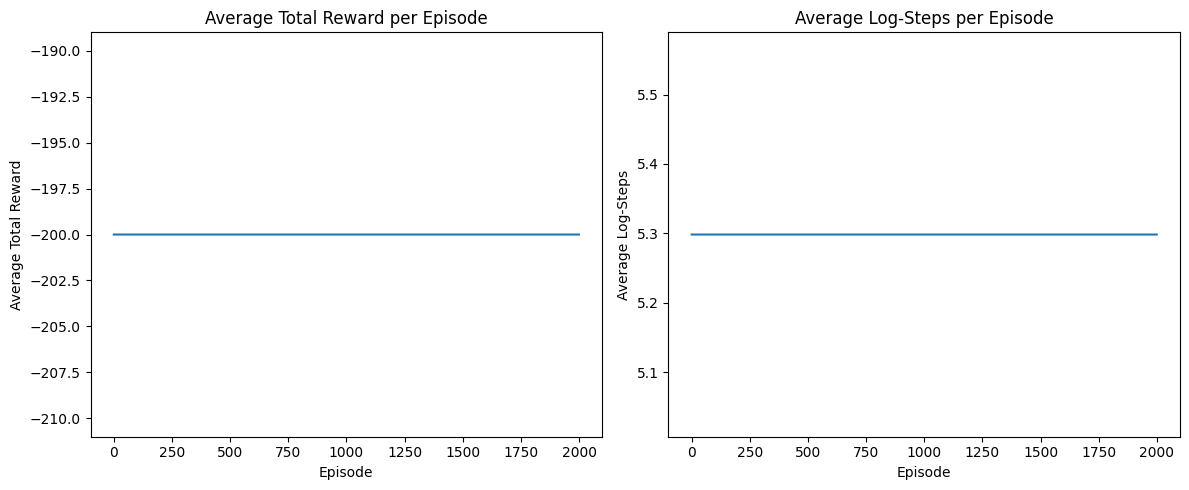

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


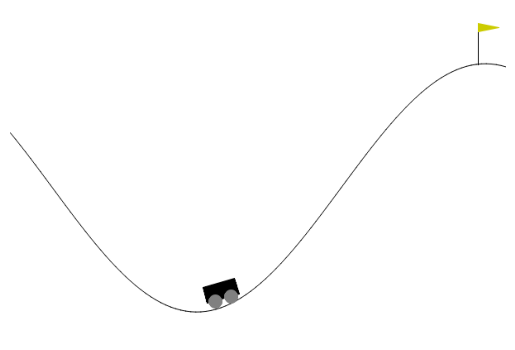

In [ ]:
# # Your code here


import numpy as np
import gym
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import matplotlib.animation as animation

# Initialize Gym environment and the agent
env = gym.make('MountainCar-v0')
agent = ActorCriticWithEligibilityTraces(env, actor_lr=0.01, critic_lr=0.01, gamma=0.99, lambda_=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, fourier_order=3)

# Training parameters
num_episodes = 2000
max_timesteps_per_episode = 400
num_runs = 50

# To store the sum of rewards and number of steps per episode for all runs
all_rewards = np.zeros((num_runs, num_episodes))
all_steps = np.zeros((num_runs, num_episodes))

# Main training loop
for run in tqdm(range(num_runs), desc='Runs'):
    for episode in range(num_episodes):
        state = env.reset()
        state = agent.transform_state(state)
        total_reward = 0
        done = False
        t = 0
        while not done and t < max_timesteps_per_episode:
            action = agent.policy(state)
            next_state, reward, done, _ = env.step(action)
            next_state = agent.transform_state(next_state)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            t += 1
        all_rewards[run, episode] = total_reward
        all_steps[run, episode] = t

# Averaging over runs
average_rewards = np.mean(all_rewards, axis=0)
average_steps = np.mean(all_steps, axis=0)

# Plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(average_rewards)
plt.title('Average Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')

plt.subplot(1, 2, 2)
plt.plot(np.log(average_steps))
plt.title('Average Log-Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Log-Steps')

plt.tight_layout()
plt.show()

# Animate the last episode
# Reset the environment and get the initial state
state = env.reset()
state = agent.transform_state(state)
frames = []

for t in range(max_timesteps_per_episode):
    frames.append(env.render(mode="rgb_array"))
    action = agent.policy(state)
    state, _, done, _ = env.step(action)
    state = agent.transform_state(state)
    if done:
        break

env.close()

# Display the animation
fig = plt.figure()
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
plt.show()

